In [1]:
import os
import json
import time
#import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy.signal as signal
import h5py
import pickle
#from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

import pygama.lgdo.lh5_store as lh5
#from pygama.dsp import build_dsp
#from pygama.dsp.processors.linear_slope_fit import linear_slope_fit
#from pygama.dsp.processors.bl_subtract import bl_subtract

from multihist import Hist1d, Histdd
from datetime import datetime, timezone
from legendmeta import LegendMetadata
meta_path = '/data1/users/dandrea/software/legend-metadata'
lmeta = LegendMetadata(path=meta_path)
chmap = lmeta.hardware.configuration.channelmaps.on("20230312T043356Z")

import pulser_analysis as pa
import analysis_utility as au

%load_ext autoreload
%autoreload 2

In [2]:
run, period = 0, 3
run, period = f'r{run:03}', f'p{period:02}'

prod_dir = '/data2/public/prodenv/prod-blind/tmp/auto/generated'
dsp_dir = f'{prod_dir}/tier/dsp/phy/{period}/{run}'
raw_dir = f'/data2/public/prodenv/prod-orig/archive/raw-v01.00/generated/tier/raw/phy/{period}/{run}'
dsp_config = f'{prod_dir}/par/dsp/cal/p03/r000/l200-p03-r000-cal-20230311T235840Z-par_dsp.json'
hit_config = f'{prod_dir}/par/hit/cal/p03/r000/l200-p03-r000-cal-20230311T235840Z-par_hit.json'
ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A', 'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
ge_drift = ['V01406A', 'V01415A', 'V01387A', 'P00665C','P00748B', 'P00748A']
ge_keys = [ch for ch in ge_all if ch not in ge_off]
ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
ge_rawid = [chmap[ch]['daq']['rawid']  for ch in ge_keys]
ge_table = [f'ch{id}' for id in ge_rawid]
nn = len(ge_table)
puls = [ch for ch in chmap.keys() if chmap[ch]['system']=='puls']
puls_rawid = [chmap[ch]['daq']['rawid']  for ch in puls]
puls_table = [f'ch{id}' for id in puls_rawid]
with open(dsp_config, "r") as file:
    dsp_pars = json.load(file)

In [9]:
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
base_colors = [c for c in mcolors.BASE_COLORS.keys()]
def moving_average(x, w=10):
    nn = len(x)
    a = np.zeros(nn)
    for i in range(nn):
        if i > w/2: ll = int(i - w/2)
        else: ll = 0
        if i < nn - w/2 - 1: hh = int(i+w/2)
        else: hh = int(nn-1)
        a[i] = np.mean(x[ll:hh])
    return a

In [ ]:
def ene_stability_old(det_names, chmap, dsp_dir, hit_config, ene_type ='cuspEmax', n_file = None, bins = 100, pulser = True,
                  raw_dir = None, plot = False, rlim = (-0.05,0.05)):
    rspace = np.linspace(rlim[0]*5,rlim[1]*5,bins*5)
    if plot: fig1, ax1 = plt.subplots(figsize=(12,6.75), facecolor='white')
    perc = np.zeros((len(det_names),bins-1))
    perc_au = np.zeros((len(det_names),bins-1))
    for ii, det_name in enumerate(det_names):
        fcid = int(chmap[det_name]['daq']['rawid'])
        chn = f'ch{fcid:03}'
        count = 0
        start = time.time()
        for p, d, files in os.walk(dsp_dir):
            d.sort()
            for i, f in enumerate(sorted(files)):
                if (f.endswith(".lh5")) & ("dsp" in f):
                    f_dsp = h5py.File(f"{dsp_dir}/{f}",'r')
                    if raw_dir is not None:
                        f_raw = f.replace('dsp','raw')
                        f_raw = h5py.File(f'{raw_dir}/{f_raw}','r')
                        wfs0 = f_raw[f'{chn}/raw/waveform/values'][:]
                    if count == 0:
                        times = f_dsp[f'{chn}/dsp/timestamp'][:]
                        trapTmax = f_dsp[f'ch1027201/dsp/trapTmax'][:]
                        ene = f_dsp[f'{chn}/dsp/{ene_type}'][:]
                        baselines = f_dsp[f'{chn}/dsp/baseline'][:]
                        if raw_dir is not None: wfs = wfs0
                    else: 
                        times = np.append(times, f_dsp[f'{chn}/dsp/timestamp'][:], axis=0)
                        trapTmax = np.append(trapTmax, f_dsp[f'ch1027201/dsp/trapTmax'][:], axis=0)
                        ene = np.append(ene, f_dsp[f'{chn}/dsp/{ene_type}'][:], axis=0)
                        baselines = np.append(baselines, f_dsp[f'{chn}/dsp/baseline'][:], axis=0)
                        if raw_dir is not None: wfs = np.append(wfs, wfs0, axis=0)
                    #if wfs_plot and (count%10)==0: print('File n.',count,'Tot. events',len(times),'Sel. waveforms',len(times_wf))
                    #if (count%10)==0: print('File n.',count,'Tot. events',len(times))
                    count += 1
                if n_file is not None and count >= n_file: break
        #print('File n.',count,'Tot. events',len(times))
        with open(hit_config, "r") as file:
            hit = json.load(file)
        try:
            m_cal = hit[chn]['operations']['cuspEmax_ctc_cal']['parameters']['a']
            q_cal = hit[chn]['operations']['cuspEmax_ctc_cal']['parameters']['b']
            ene = m_cal * ene + q_cal
            yunit = 'keV'
        except:
            yunit = 'ADC'
            #print('Calibration parameters not found')
        if pulser:
            ene = ene[trapTmax>100]
            times = times[trapTmax>100]
            if raw_dir is not None: wfs = wfs[trapTmax>100]
        else:
            ene = ene[trapTmax<100]
            times = times[trapTmax<100]
            if raw_dir is not None: wfs = wfs[trapTmax<100]
        
        tspace = np.linspace(times.min(),times.max(),bins)
        dt = [datetime.fromtimestamp(ts) for ts in times]
        dspace = [datetime.fromtimestamp(ts) for ts in tspace]
        
        """fig, ax = plt.subplots(figsize=(12,6.75), facecolor='white')
        elim = (ene.mean()-0.5,ene.mean()+0.5)
        espace = np.linspace(elim[0],elim[1],bins)
    
        ph = Histdd(dt, ene, bins=(dspace, espace))
        ph_ = Histdd(times, ene, bins=(tspace, espace))
        plt.sca(ax)
        ax.axhline(ene.mean(),c='k',ls=':')
        ax.set_title(f'{det_name} - {chn}')
        #ph.plot(log_scale=True,cmap='viridis',colorbar=False)
        perc50 = ph_.percentile(percentile=50, axis=1)
        ax.plot(dspace[1:], perc50,c=base_colors[ii],ls='',marker='o',label='50% percentile')
        ax.set_ylim(elim[0],elim[1])
        ax.set_ylabel(f'energy [{yunit}]')"""
        if raw_dir is not None:
            print('Plotting waveforms')
            wf_dict = {}
            fig0, ax0 = plt.subplots(figsize=(12,6.75), facecolor='white')
            for j, wf in enumerate(wfs):
                if j >= 10: break
                ax0.plot(wf)
        
        # relative shift
        ene_rel = (ene-ene.mean())/ene.mean()*1e6
        #ph = Histdd(dt, ene_rel, bins=(dspace, rspace))
        ph_ = Histdd(times, ene_rel, bins=(tspace, rspace))
        
        #ph.plot(log_scale=True,cmap='viridis',colorbar=False)
        perc50 = ph_.percentile(percentile=50, axis=1)
        perc50_av = moving_average(perc50)
        if plot:
            plt.sca(ax1)
            ax1.plot(dspace[1:], perc50, c=base_colors[ii],ls='',marker='o',alpha=0.5)
            ax1.plot(dspace[1:], perc50_av, c=base_colors[ii],ls='-',lw=2,label=f'{det_name}')
            print(dspace[0],dspace[-1])
        perc[ii] = (perc50_av-perc50_av.mean())
        perc_au[ii] = perc[ii]/perc[ii].max()
    corr = np.sum([perc[0][i]*perc[1][i] for i in range(bins-1)])
    corr /= np.sqrt(np.sum(perc[0]*perc[0])*np.sum(perc[1]*perc[1]))
    print('Correlation with',det_names[1],corr)
    if plot:
        ax1.legend(title=f'correlation = {corr*100:.1f}%',loc='upper right')
        ax1.axhline(0,c='k',ls=':')
        ax1.set_ylim(rlim[0],rlim[1])
        ax1.set_ylabel('energy shift [ppm]')
        #fig1.savefig(f'pulser_stability/pulser_stability_{det_names[0]}-{det_names[-1]}.png',dpi=300, bbox_inches='tight')
    return corr, perc_au

In [ ]:
corr = np.zeros(len(ge_keys))
for i, ge in enumerate(ge_keys[:1]):
    corr[i], pulser = ene_stability([puls[1],ge_keys[i]], chmap, dsp_dir, hit_config, n_file = 7, pulser=1, rlim = (-500,500), plot=1)

In [10]:
def ene_stability(
    period,
    runs,
    chmap,
    hit_config,
    nstring = None,
    ene_type ='cuspEmax',
    n_file = None,
    bins = 80,
    pulser = True,
    rlim = (-0.05,0.05),
    s_file = 0
):
    rspace = np.linspace(rlim[0]*5,rlim[1]*5,bins*5)
    
    ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A', 'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
    ge_drift = ['V01406A', 'V01415A', 'V01387A', 'P00665C','P00748B', 'P00748A']
    ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
    ge_all = [ch for ch in ge_all if ch not in ge_off]
    ge_all = [ch for ch in ge_all if ch not in ge_drift]
    strings = np.array([int(chmap[ch]['location']['string']) for ch in chmap.keys() if chmap[ch]['system']=='geds'])
    puls = [ch for ch in chmap.keys() if chmap[ch]['system']=='puls']
    
    if nstring is None: nstring = strings.max()
    corr = np.zeros(len(ge_all))
    nchn = 0
    fig1, axis1 = plt.subplots(nrows=4, ncols=3,figsize=(40,40), facecolor='white')
    fig2, axis2 = plt.subplots(nrows=4, ncols=3,figsize=(40,40), facecolor='white')
    for string in range(1,nstring+1):
        ax1 = axis1.flat[string-1]
        ax2 = axis2.flat[string-1]
        ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_keys = [ch for ch in ge_keys if ch not in ge_off]
        ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
        pulser_plot = True
        for ge_key in ge_keys:
            if ge_key == 'B00089D': continue
            perc = np.zeros((2,bins-1))
            perc_au = np.zeros((2,bins-1))
            for ii, det_name in enumerate([puls[1],ge_key]):
                fcid = int(chmap[det_name]['daq']['rawid'])
                chn = f'ch{fcid:03}'
                count = 0
                start = time.time()
                for run in runs:
                    dsp_dir = f'/data2/public/prodenv/prod-blind/tmp/auto/generated/tier/dsp/phy/{period}/{run}'
                    #print('Opening files for',run)
                    for p, d, files in os.walk(dsp_dir):
                        d.sort()
                        for i, f in enumerate(sorted(files)):
                            if (f.endswith(".lh5")) & ("dsp" in f) & (i>=s_file):
                                #if i == 0: print(f)
                                f_dsp = h5py.File(f"{dsp_dir}/{f}",'r')
                                times0 = f_dsp[f'{chn}/dsp/timestamp'][:]
                                #times0 = tstart - times0[0] + f_dsp[f'{chn}/dsp/timestamp'][:]
                                #print([datetime.fromtimestamp(t) for t in times0[:10]])
                                if count == 0:
                                    tstart = f.split('-')[-1].split('_')[0]
                                    #tstart = datetime.strptime(tstart, "%Y%m%dT%H%M%SZ").timestamp()
                                    times = times0
                                    trapTmax = f_dsp[f'ch1027201/dsp/trapTmax'][:]
                                    puls_times = f_dsp[f'ch1027201/dsp/timestamp'][:]
                                    ene = f_dsp[f'{chn}/dsp/{ene_type}'][:]
                                    baselines = f_dsp[f'{chn}/dsp/baseline'][:]
                                else: 
                                    times = np.append(times, times0, axis=0)
                                    trapTmax = np.append(trapTmax, f_dsp[f'ch1027201/dsp/trapTmax'][:], axis=0)
                                    puls_times = np.append(puls_times, f_dsp[f'ch1027201/dsp/timestamp'][:], axis=0)
                                    ene = np.append(ene, f_dsp[f'{chn}/dsp/{ene_type}'][:], axis=0)
                                    baselines = np.append(baselines, f_dsp[f'{chn}/dsp/baseline'][:], axis=0)
                                #print('\nener size',len(ene))
                                #print('puls size',len(trapTmax))
                                #if wfs_plot and (count%10)==0: print('File n.',count,'Tot. events',len(times),'Sel. waveforms',len(times_wf))
                                #if (count%10)==0: print('File n.',count,'Tot. events',len(times))
                                count += 1
                            if n_file is not None and count >= n_file: break
                #print('File n.',count,'Tot. events',len(times))
                if len(times) > len(puls_times):
                    print('cutting times and ene')
                    ene = np.array([e for t,e in zip(times,ene) if t in puls_times])
                    times = np.array([t for t in times if t in puls_times])
                with open(hit_config, "r") as file:
                    hit = json.load(file)
                """try:
                    m_cal = hit[chn]['operations']['cuspEmax_ctc_cal']['parameters']['a']
                    q_cal = hit[chn]['operations']['cuspEmax_ctc_cal']['parameters']['b']
                    ene = m_cal * ene + q_cal
                    yunit = 'keV'
                except:"""
                a = True
                if a:
                    yunit = 'ADC'
                    #print('Calibration parameters not found')
                    #print('Total events n.',len(ene))
                    shift = 150
                    if pulser:
                        mask = (trapTmax>100)
                        #mean = ene[mask].mean()
                        ene = ene[mask]
                        #print('Pulser events n.',len(ene))
                        times = times[mask]
                    else:
                        ene = ene[trapTmax<100]
                        times = times[trapTmax<100]
        
                time_space = np.linspace(times.min(),times.max(),bins)
                dt = [datetime.fromtimestamp(ts) for ts in times]
                date_space = [datetime.fromtimestamp(ts) for ts in time_space]
                dspace = [datetime.fromtimestamp(ts) for ts in np.linspace(times.min(),times.max(),20)]
        
                xticks = [mdates.date2num(x) for x in dspace]
                xticklabels = [x.strftime('%Y/%m/%d %H:%M') for x in dspace]
        
                # relative shift
                ene_rel = (ene-ene.mean())/ene.mean()*1e6
                #print('mean',ene.mean())
                #ph = Histdd(dt, ene_rel, bins=(dspace, rspace))
                ph_ = Histdd(times, ene_rel, bins=(time_space, rspace))

                #ph.plot(log_scale=True,cmap='viridis',colorbar=False)
                perc50 = ph_.percentile(percentile=50, axis=1)
                perc50_av = moving_average(perc50)
                perc50_av -= perc50_av.mean()
                
                plt.sca(ax1)
                #ax1.plot(date_space[1:], perc50, c=base_colors[ii],ls='',marker='o',alpha=0.5)
                if det_name == 'PULS01ANA':
                    perc50_puls = perc50_av
                    if pulser_plot:
                        ax1.plot(date_space[1:], perc50_puls, c='b',ls='-',lw=2,label=f'{det_name}')
                        pulser_plot = False
                else:
                    perc50_ge = perc50_av
                    #ax1.plot(date_space[1:], perc50_av,ls='--',lw=2,label=f'{det_name}')
                perc[ii] = perc50_av
                perc_au[ii] = perc[ii]/perc[ii].max()
            corr[nchn] = np.sum([perc[0][i]*perc[1][i] for i in range(bins-1)])
            corr[nchn] /= np.sqrt(np.sum(perc[0]*perc[0])*np.sum(perc[1]*perc[1]))
            print(ge_key,'string',string,f'correlation = {corr[nchn]} %',date_space[0],'->',date_space[-1])
            ax1.plot(date_space[1:], perc50_ge, ls='-',lw=1,label=f'{det_name} - corr = {corr[nchn]*100:.2f}%')
            perc50_ge -= perc50_puls
            ax2.plot(date_space[1:], perc50_ge, ls='-',lw=1,label=f'{det_name} - corr = {corr[nchn]*100:.2f}%')
            nchn += 1
        ax1.axhline(0,c='k',ls=':')
        ax1.set_ylim(rlim[0],rlim[1])
        ax1.set_ylabel('energy shift [ppm]')
        plt.xticks(rotation=30)
        ax1.set_xticks(xticks)
        ax1.set_xticklabels(xticklabels)
        ax1.legend(title=f'string {string}')#loc='upper right')
        plt.sca(ax2)
        ax2.axhline(0,c='k',ls=':')
        ax2.set_ylim(rlim[0],rlim[1])
        ax2.set_ylabel('energy shift [ppm]')
        plt.xticks(rotation=30)
        ax2.set_xticks(xticks)
        ax2.set_xticklabels(xticklabels)
        ax2.legend(title=f'string {string}')#loc='upper right')
    #fig1.savefig(f'l200-{period}/pulser_stability/pulser_stability_{runs[0]}_{runs[-1]}.png',dpi=150, bbox_inches='tight')
    #fig2.savefig(f'l200-{period}/pulser_stability/pulser_stability_rem_{runs[0]}_{runs[-1]}.png',dpi=150, bbox_inches='tight')
    return corr, perc_au

In [ ]:
corr, pulser = ene_stability(period, ['r000'], chmap, hit_config, nstring=1, n_file=None, rlim = (-200,300))

In [ ]:
def plot_correlation(correlation, chmap, nstring = None, plot_dir = None ):
    fig0, axis0 = plt.subplots(figsize=(20,8), facecolor='white')
    
    ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A', 'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
    ge_drift = ['V01406A', 'V01415A', 'V01387A', 'P00665C','P00748B', 'P00748A']
    ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
    ge_all = [ch for ch in ge_all if ch not in ge_off]
    ge_all = [ch for ch in ge_all if ch not in ge_drift]
    strings = np.array([int(chmap[ch]['location']['string']) for ch in chmap.keys() if chmap[ch]['system']=='geds'])
    if nstring is None: nstring = strings.max()
    numb = 0
    mean = correlation.mean()
    std = correlation.std()/np.sqrt(len(correlation))
    for string in range(1,nstring+1):
        ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_keys = [ch for ch in ge_keys if ch not in ge_off]
        ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
        ii, ff = numb, numb+len(ge_keys)
        numb += len(ge_keys)
        ge_rawid = [chmap[ch]['daq']['rawid']  for ch in ge_keys]
        ge_table = [f'ch{id}' for id in ge_rawid]
        corr = np.array([corr for corr in correlation[ii:ff]])
        if len(corr)>0:
            mean_, mean_err_ = corr.mean(), corr.std()/np.sqrt(len(corr))
            axis0.plot(ge_all[ii:ff],corr,marker='o',ls='',label=f'String {string}, mean {mean_:.2f}$\pm${mean_err_:.2f}')
    axis0.axhline(mean,color='r',label=f'mean value {mean:.2f}$\pm${std:.2f}')
    axis0.set_ylabel('correlation')
    axis0.set_ylim(-1,1)
    axis0.set_xticklabels(ge_all, rotation = 90, ha="right")
    axis0.legend(loc='lower right')
    axis0.grid()
    fig0.savefig(f'pulser_stability/p03_r{run:03}/correlation.png',dpi=150, bbox_inches='tight')

In [ ]:
plot_correlation(corr, chmap, nstring = None)

# Temperatures from L-200 Slow Control

In [4]:
# Pull out some slow controls data and plot it on top of A/E vs time
# This is just an example. We don't expect to see any actual correlation between
# these two variables.
# For more info on the slow controls interface, see
# https://codimd.web.cern.ch/s/DIoXpZeff# and
# https://pylegendmeta.readthedocs.io/en/latest/index.html
# needed to install psycopg2, and also set up an ssh proxy:
# - Make .ssh/config with the following in it:
# Host lngs-proxy
# HostName legend-gw-1.lngs.infn.it
# LocalForward 5432 192.168.39.86:5432
# ControlMaster auto
# ControlPath ~/.ssh/sockets/%r@%h:%p
# LogLevel DEBUG
# - mkdir .ssh/sockets
# - then at the command line: ssh lngs-proxy
# - set env variable LEGEND_SCDB_PW (Luigi had the password)
# Later, will try to implement / show methods to "browse" the SCDB
os.environ["LEGEND_SCDB_PW"] = 'legend00'
from legendmeta import LegendSlowControlDB
scdb = LegendSlowControlDB()
scdb.connect()

In [ ]:
from sqlalchemy import inspect
inspect(scdb.connection.engine).get_table_names()

In [ ]:
c = scdb.dataframe("select * from rack_snap where (name='Temp')AND(rack='CleanRoom-DaqRight')AND(sensor='Temp-2')AND(tstamp>'2023-03-12')AND(tstamp<'2023-03-18') order by tstamp")

In [27]:
import matplotlib
from scipy import signal
def plot_clearoom_temp(
    bins=100,
    pulser=None,
    day='2023-03-12',
    stime='05:34:23',
    ftime='08:01:43',
    day2='2023-03-17'
):
    if day2 is None: day2 = day
    #crsc = scdb.dataframe(f"select * from {snap} where name='{variable}' order by tstamp")
    cr1r = scdb.dataframe(f"select * from rack_snap where (name='Temp')AND(rack='CleanRoom-DaqRight')AND(sensor='Temp-1')AND(tstamp>'{day}T{stime}')AND(tstamp<'{day2}T{ftime}') order by tstamp")
    cr2r = scdb.dataframe(f"select * from rack_snap where (name='Temp')AND(rack='CleanRoom-DaqRight')AND(sensor='Temp-2')AND(tstamp>'{day}T{stime}')AND(tstamp<'{day2}T{ftime}') order by tstamp")
    cr1l = scdb.dataframe(f"select * from rack_snap where (name='Temp')AND(rack='CleanRoom-DaqLeft')AND(sensor='Temp-1')AND(tstamp>'{day}T{stime}')AND(tstamp<'{day2}T{ftime}') order by tstamp")
    cr2l = scdb.dataframe(f"select * from rack_snap where (name='Temp')AND(rack='CleanRoom-DaqLeft')AND(sensor='Temp-2')AND(tstamp>'{day}T{stime}')AND(tstamp<'{day2}T{ftime}') order by tstamp")
    
    temps1r, temps2r = np.array(cr1r['value'], dtype=float), np.array(cr2r['value'], dtype=float)
    temps1l, temps2l = np.array(cr1l['value'], dtype=float), np.array(cr2l['value'], dtype=float)
    temps1r, temps2r = moving_average(temps1r,w=50), moving_average(temps2r,w=50)
    temps1l,temps2l = moving_average(temps1l,w=50), moving_average(temps2l,w=50)
    mean1r =  temps1r.mean()
    mean2r =  temps2r.mean()
    mean1l =  temps1l.mean()
    mean2l =  temps2l.mean()
    temps1r -= mean1r
    temps2r -= mean2r
    temps1l -= mean1l
    temps2l -= mean2l
    times1r, times2r = np.array(cr1r['tstamp'], dtype=np.datetime64), np.array(cr2r['tstamp'], dtype=np.datetime64)
    times1l, times2l = np.array(cr1l['tstamp'], dtype=np.datetime64), np.array(cr2l['tstamp'], dtype=np.datetime64)
    #locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    fig, ax = plt.subplots(figsize=(12,6.75), facecolor='white')
    #ax.xaxis.set_major_locator(locator)
    myFmt = matplotlib.dates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    
    ax.plot(times1r, temps1r, color='r', label=f"DaqRight Temp-1, mean = {mean1r:.1f} C")
    ax.plot(times2r, temps2r, color='m', label=f"DaqRight Temp-2, mean = {mean2r:.1f} C")
    ax.plot(times1l, temps1l, color='g', label=f"DaqLeft Temp-1, mean = {mean1l:.1f} C")
    ax.plot(times2l, temps2l, color='k', label=f"DaqLeft Temp-2, mean = {mean2l:.1f} C")
    ax.set_ylabel('temperature variation [K]')
    ax.legend(loc='upper right')
    fig1, ax1 = plt.subplots(figsize=(12,6.75), facecolor='white')
    temps1r /= temps1r.max()
    temps2r /= temps2r.max()
    temps1l /= temps1l.max()
    temps2l /= temps2l.max()
    temps1r = signal.resample(temps1r, bins)
    temps2r = signal.resample(temps2r, bins)
    temps1l = signal.resample(temps1l, bins)
    temps2l = signal.resample(temps2l, bins)
    if pulser is not None:
        corr1r = np.sum([pulser[i]*temps1r[i] for i in range(bins-1)])
        corr1r /= np.sqrt(np.sum(pulser*pulser)*np.sum(temps1r*temps1r))
        corr2r = np.sum([pulser[i]*temps2r[i] for i in range(bins-1)])
        corr2r /= np.sqrt(np.sum(pulser*pulser)*np.sum(temps2r*temps2r))
        corr1l = np.sum([pulser[i]*temps1l[i] for i in range(bins-1)])
        corr1l /= np.sqrt(np.sum(pulser*pulser)*np.sum(temps1l*temps1l))
        corr2l = np.sum([pulser[i]*temps2l[i] for i in range(bins-1)])
        corr2l /= np.sqrt(np.sum(pulser*pulser)*np.sum(temps2l*temps2l))
        ax1.plot(pulser, color='b',lw=3, label="PULS")
        ax1.plot(temps1r, color='r', label=f"DaqRight Temp-1, corr = {corr1r:.2f}")
        ax1.plot(temps2r, color='m', label=f"DaqRight Temp-2, corr = {corr2r:.2f}")
        ax1.plot(temps1l, color='g', label=f"DaqLeft Temp-1, corr = {corr1l:.2f}")
        #ax1.plot(temps2l, color='k', label=f"DaqLeft Temp-2, corr = {corr2l:.2f}")
    else:
        ax1.plot(temps1r, color='r', label=f"DaqRight Temp-1, mean = {mean1r:.1f} C")
        ax1.plot(temps2r, color='m', label=f"DaqRight Temp-2, mean = {mean2r:.1f} C")
        ax1.plot(temps1l, color='g', label=f"DaqLeft Temp-1, mean = {mean1l:.1f} C")
        ax1.plot(temps2l, color='k', label=f"DaqLeft Temp-2, mean = {mean2l:.1f} C")
    ax1.set_ylabel('variation [a.u.]')
    ax1.legend(loc='upper right')
    fig.savefig(f'l200-p03/pulser_stability/clean-room_temperatures.png',dpi=150, bbox_inches='tight')
    fig1.savefig(f'l200-p03/pulser_stability/clean-room_temp_vs_pulser.png',dpi=150, bbox_inches='tight')

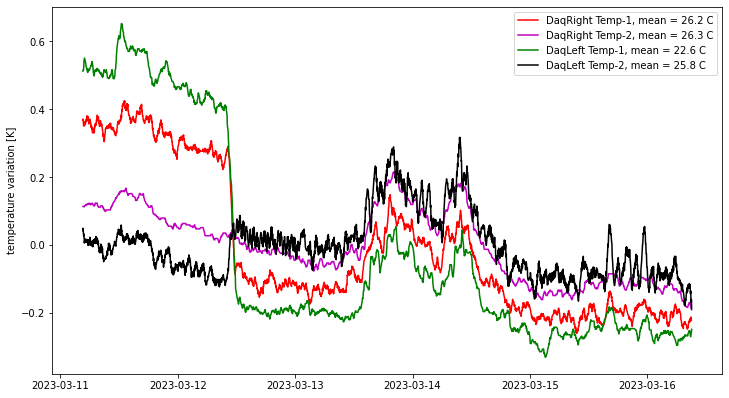

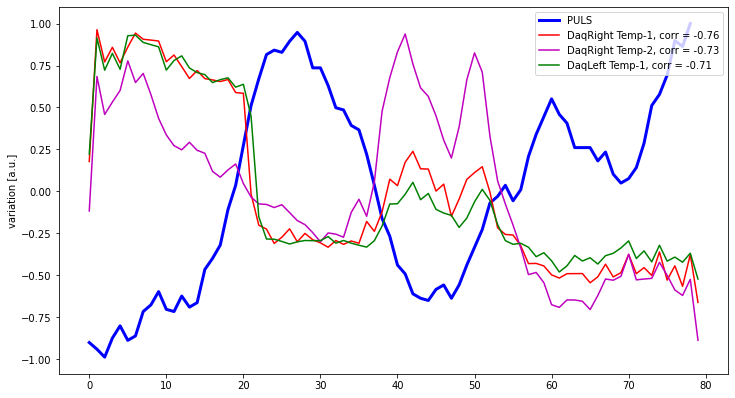

In [28]:
plot_clearoom_temp(bins=80,pulser=pulser[0], day='2023-03-12',stime='05:34:23',day2='2023-03-17',ftime='10:06:02')